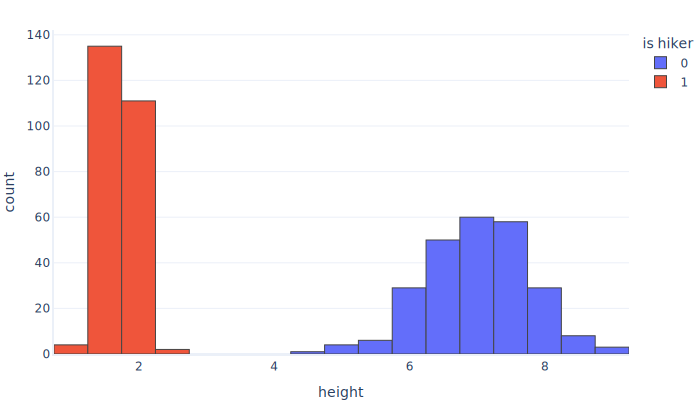

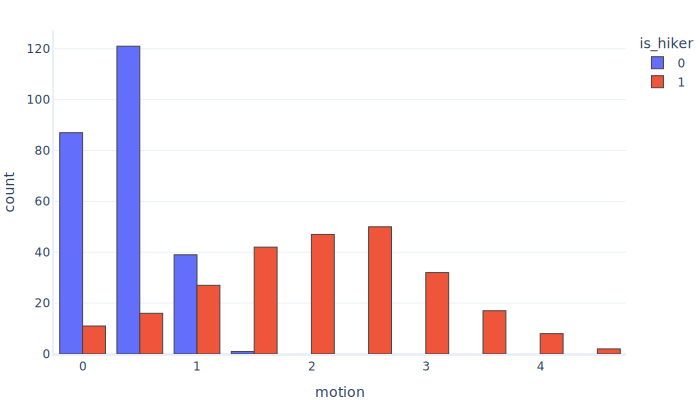

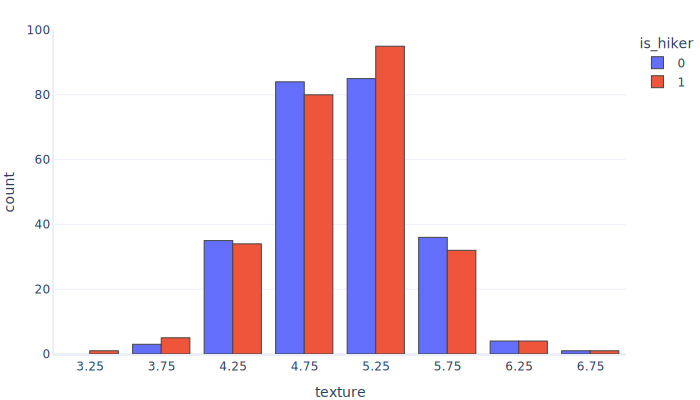

In [1]:
import numpy
import pandas
import graphing
import sklearn.model_selection
import plotly.io as pio

pio.renderers.default = "svg"


# Load our data from disk
df = pandas.read_csv("hiker_or_tree.csv", delimiter="\t")

# Split into train and test
train, test =  sklearn.model_selection.train_test_split(df, test_size=0.5, random_state=1)

# Graph our three features
graphing.histogram(test, label_x="height", label_colour="is_hiker", show=True)
graphing.multiple_histogram(test, label_x="motion", label_group="is_hiker", nbins=12, show=True)
graphing.multiple_histogram(test, label_x="texture", label_group="is_hiker", nbins=12)

We have three visual features - `height`, `motion`, and `texture`. Our goal here is not to optimize a model, but to explore ROC curves, so we'll work with just one at a time.

Before diving into it, take a look at the distributions above. We can see that we should be able to use height to separate hikers from trees quite easily. Motion will be slightly more difficult, presumably because trees blow in the wind, and some hikers are found sitting down. Texture seems much the same for hikers and trees.

## A perfect model
What would a perfect ROC look like? If we had a perfectly designed model, it would calculate "0% chance of hiker" when it saw any tree and "100% of hiker" when it saw any hiker. This means that, so long as the decision threshold was > 0% and < 100%, it would have perfect performance. Between these thresholds, the true positive rate would always be 1, and the false positive rate would always be 0. 

Don't worry about the thresholds of exactly 0 and 1 (100%). At 0 we are forcing a model to return a False value and at 1 we are forcing it to return True.

It's almost impossible to train a model that is so perfect, but for the sake of learning, let's pretend we have done so, predicting the `is_hiker` label based on `height`.

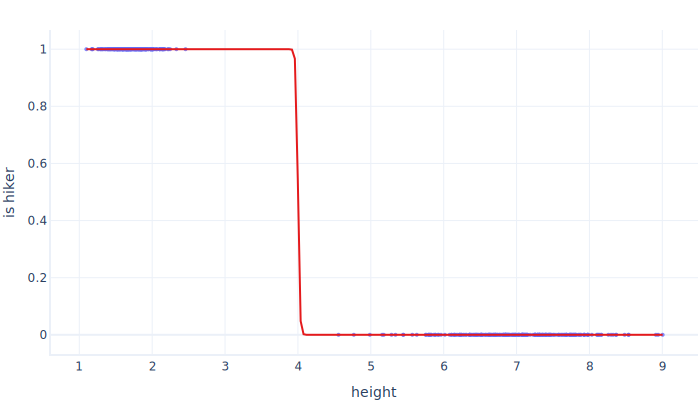

In [2]:
import statsmodels.api

# Create a fake model that is perfect at predicting labels
class PerfectModel:
    def predict(self, x):
        # The perfect model believes that hikers are all
        # under 4m tall
        return 1 / (1 + numpy.exp(80*(x - 4)))
    
model = PerfectModel()

graphing.scatter_2D(test, trendline=model.predict)

Our red line is our model, and our blue dots are our datapoints. On the y-axis `0` means tree, and `1` means hiker. We can see our perfect model is passing through every single point.

Now we want to make an ROC curve for this perfect model. There are automated ways to do this, but we're here to learn! It's not so hard to do ourselves. We just need to break it down into steps.

Remember than an ROC curve plots the _true positive rate_ (TPR) against the _false positive rate_ (FPR). Let's make a function that can calculate these for us. If you're rusty on what these terms mean, pay attention to the code comments:

In [3]:
def calculate_tpr_fpr(prediction, actual):
    '''
    Calculates true positive rate and false positive rate

    prediction: the labels predicted by the model
    actual:     the correct labels we hope the model predicts
    '''

    # To calculate the true positive rate and true negative rate we need to know
    # TP - how many true positives (where the model predicts hiker, and it is a hiker)
    # TN - how many true negatives (where the model predicts tree, and it is a tree)
    # FP - how many false positives (where the model predicts hiker, but it was a tree)
    # FN - how many false negatives (where the model predicts tree, but it was a hiker)

    # First, make a note of which predictions were 'true' and which were 'false'
    prediction_true = numpy.equal(prediction, 1)
    prediction_false= numpy.equal(prediction, 0)

    # Now, make a note of which correct results were 'true' and which were 'false'
    actual_true = numpy.equal(actual, 1)
    actual_false = numpy.equal(actual, 0)

    # Calculate TP, TN, FP, and FN
    # The combination of sum and '&' counts the overlap
    # For example, TP calculates how many 'true' predictions 
    # overlapped with 'true' labels (correct answers)
    TP = numpy.sum(prediction_true  & actual_true)
    TN = numpy.sum(prediction_false & actual_false)
    FP = numpy.sum(prediction_true  & actual_false)
    FN = numpy.sum(prediction_false & actual_true)

    # Calculate the true positive rate
    # This is the proportion of 'hiker' labels that are identified as hikers
    tpr = TP / (TP + FN)

    # Calculate the false positive rate 
    # This is the proportion of 'tree' labels that are identified as hikers
    fpr = FP / (FP + TN)

    # Return both rates
    return tpr, fpr

print("Ready!")

Ready!



Now remember that to make an ROC curve, we calculate TPR and FPR for a wide range of thresholds. We then plot the TPR on the y-axis and the FPR on the x-axis.

First, lets make a short method that can calculate the TPR and FPR for just one decision threshold.

In [4]:
def assess_model(model_predict, feature_name, threshold):
    '''
    Calculates the true positive rate and false positive rate of the model
    at a particular decision threshold

    model_predict: the model's predict function
    feature_name: the feature the model is expecting
    threshold: the decision threshold to use 
    '''

    # Make model predictions for every sample in the test set
    # What we get back is a probability that the sample is a hiker
    # For example, if we had two samples in the test set, we might
    # get 0.45 and 0.65, meaning the model says there is a 45% chance
    # the first sample is a hiker, and 65% chance the second is a 
    # hiker
    probability_of_hiker = model_predict(test[feature_name])
    
    # See which predictions at this threshold would say hiker
    predicted_is_hiker = probability_of_hiker > threshold

    # calculate the true and false positives rates using our
    # handy method
    return calculate_tpr_fpr(predicted_is_hiker, test.is_hiker)

print("Ready!")

Ready!


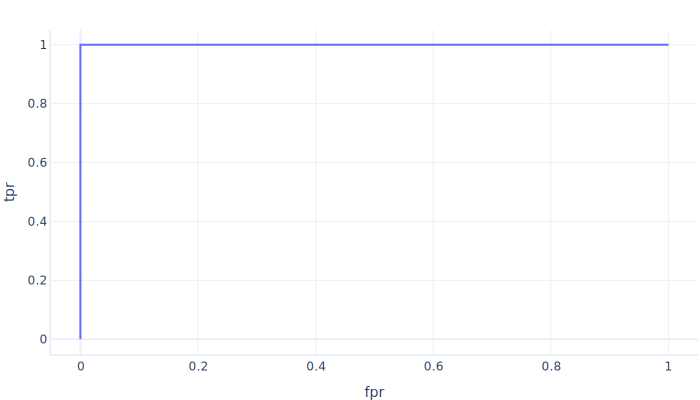

In [5]:
def create_roc_curve(model_predict, feature="height"):
    '''
    This function creates a ROC curve for a given model by testing it
    on the test set for a range of decision thresholds. An ROC curve has
    the True Positive rate on the x-axis and False Positive rate on the 
    y-axis

    model_predict: The model's predict function
    feature: The feature to provide the model's predict function
    '''

    # Calculate what the true positive and false positive rate would be if
    # we had used different thresholds. 

    #  Make a list of thresholds to try
    thresholds = numpy.linspace(0,1,101)

    false_positive_rates = []
    true_positive_rates = []

    # Loop through all thresholds
    for threshold in thresholds:
        # calculate the true and false positives rates using our
        # handy method
        tpr, fpr = assess_model(model_predict, feature, threshold)

        # save the results
        true_positive_rates.append(tpr)
        false_positive_rates.append(fpr)


    # Graph the result
    # You don't need to understand this code, but essentially we are plotting
    # TPR versus FPR as a line plot
    # -- Prepare a dataframe, required by our graphing code
    df_for_graphing = pandas.DataFrame(dict(fpr=false_positive_rates, tpr=true_positive_rates, threshold=thresholds))
    # -- Generate the plot
    fig = graphing.scatter_2D(df_for_graphing, x_range=[-0.05,1.05])
    fig.update_traces(mode='lines') # Comment our this line if you would like to see points rather than lines
    fig.update_yaxes(range=[-0.05, 1.05])

    # Display the graph
    fig.show()


# Create an roc curve for our model
create_roc_curve(model.predict)

What are we seeing here?

Except for at a threshold of 0, the model always has a true positive rate of 1. It also always has a false positive rate of 0, unless the threshold has been set to 1. Note that because we've drawn a line, it appears that there are intermediate values (such as a FPR of 0.5) but the line is simply deceiving. If you would like, comment out `fig.update_traces(mode='lines')` in the above cell and re-run to see points, rather than lines. 

Think about it - our model is perfect. Using it, we will always gets all answers correct, putting all points are in top left corner (unless the threshold is 0 or 1, which effectively mean that we are discarding the model results completely).  

## Worse-than-chance
As a counter example to understand the ROC curve, lets consider a model that is worse than chance. In fact, this model gets every single answer wrong.

This doesn't happen often in the real world, so again, we will have to fake this model as well. Let's plot this fake model against our data:

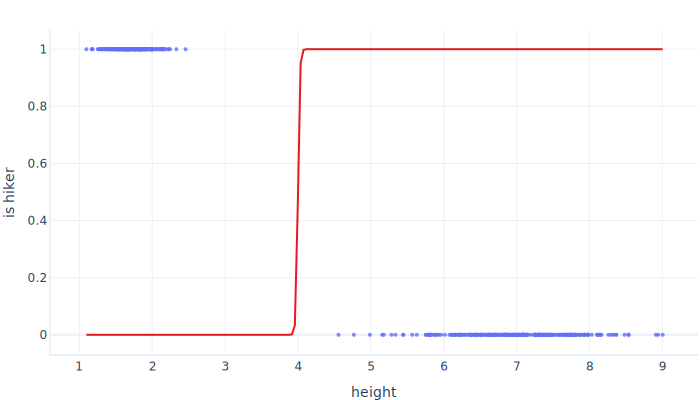

In [6]:
# Create a fake model that gets every single answer incorrect
class VeryBadModel:
    def predict(self, x):
        # This model thinks that all people are over 4m tall 
        # and all trees are shorter
        return 1 / (1 + numpy.exp(-80*(x - 4)))

model = VeryBadModel()

# Plot the model
graphing.scatter_2D(test, trendline=model.predict)

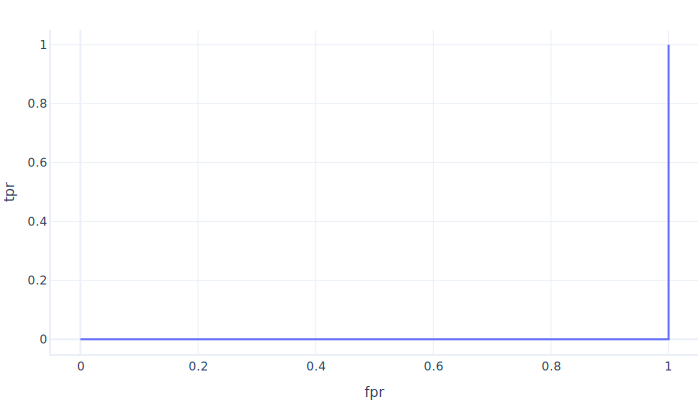

In [7]:
create_roc_curve(model.predict)


It is the opposite of the perfect model. Rather than the line reaching the top left of the graph, it reaches the bottom right. This means that the TPR is always 0 - it gets nothing right at all. In this particular example, it also always has a false positive rate of 1, so long as the threshold is less than 1.


## A model no better than chance
The previous two models we've seen are very unusual. We've learned though, that we would like the curve to be as close to the top left of the graph as possible.

What would a model be like that does no better than chance? Let's have a look by trying to fit a model to our texture feature. We know this won't work well, because we've seen that hikers and trees have the same range of image textures.

Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 3


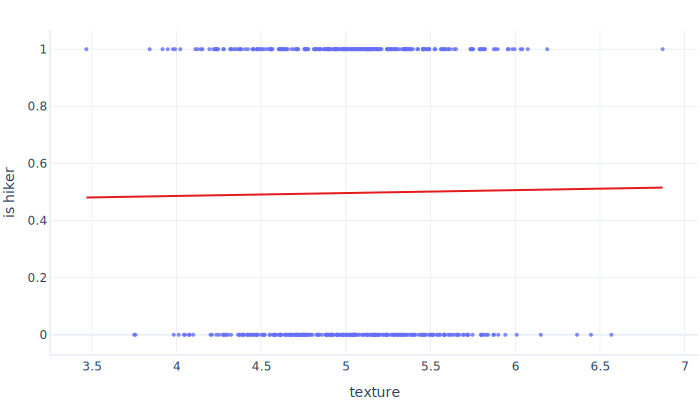

In [8]:
import statsmodels.api

# This is a helper method that reformats the data to be compatible
# with this particular logistic regression model 
prep_data = lambda x:  numpy.column_stack((numpy.full(x.shape, 1), x))

# Train a logistic regression model to predict hiker based on texture
model = statsmodels.api.Logit(train.is_hiker, prep_data(train.texture)).fit()

# Plot the model
graphing.scatter_2D(test, label_x="texture", label_y="is_hiker", trendline=lambda x: model.predict(prep_data(x)))

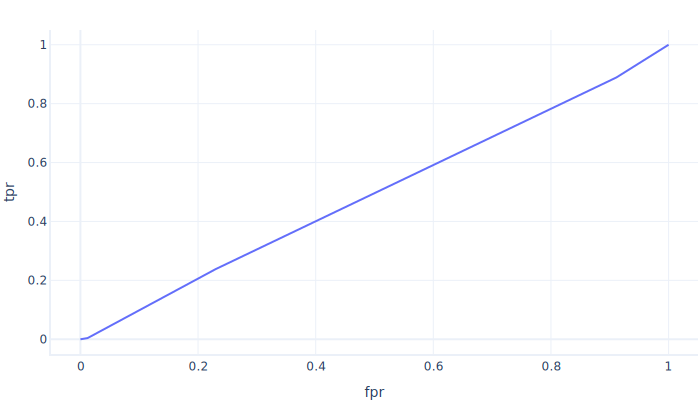

In [9]:
create_roc_curve(lambda x: model.predict(prep_data(x)), "texture")

It's a diagonal line! Why?

Remember that the model could not find a way to reliably predict the label from the feature. It is making a range of predictions but they are essentially guesswork. 

If we have a threshold of 0.5, about half of our probabilities will be above the threshold, meaning that about half of our predictions are `hiker`. Half of the labels are also hiker, but there is no correlation between the two. This means we'll get about half the predicted `hiker` labels correct (TPR = 0.5). We will also get about half the predicted `hiker` labels wrong (FPR = 0.5).

If we increased the threshold to 0.8, it would predict _hiker_ 80% of the time. Again, because this is random, it would identify about 80% of the hikers correctly (by chance), and but also 80% of the trees as hikers.

If we continued this approach for all thresholds, we would achieve a diagonal line.

## A realistic model

In the real world, we typically achieve models that perform somewhere between between pure chance (a diagonal line) and perfectly (a line that touches the top left corner).

Let's finally build a more realistic model. We'll try to predict whether a sample is a hiker or not based on motion. Our model should do OK, but it won't be perfect. This is because hikers sometimes sit still (like trees) and trees sometimes blow in the wind (moving, like a hiker).

c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:127: ValueWarning:

unknown kwargs ['add_constant']



Optimization terminated successfully.
         Current function value: 0.260202
         Iterations 8


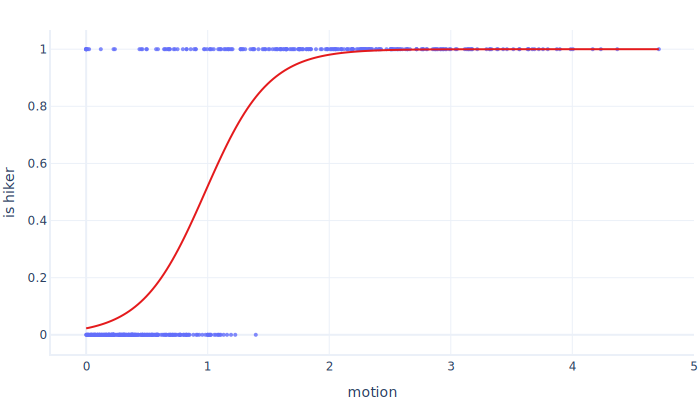

In [10]:
import statsmodels.api

# Train a logistic regression model to predict hiker based on motion
model = statsmodels.api.Logit(train.is_hiker, prep_data(train.motion), add_constant=True).fit()

# Plot the model
graphing.scatter_2D(test, label_x="motion", label_y="is_hiker", trendline=lambda x: model.predict(prep_data(x)))

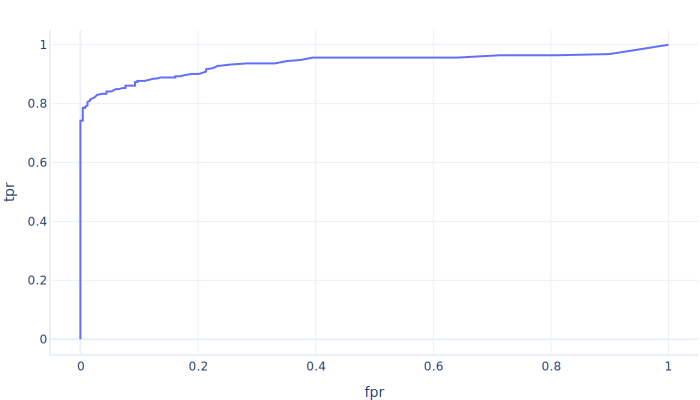

In [11]:
create_roc_curve(lambda x: model.predict(prep_data(x)), "motion")

We can see the curve bulging toward the top left corner, meaning it is working much better than chance.

This is a fairly typical ROC curve for an 'easy' machine-learning problem like this. Harder problems often see the line much more similar to a diagonal line.

By contrast, if we ever came across a line that bulged the opposite direction - to the bottom right - we would know we're doing worse than chance, and something is deeply wrong.


## Summary

We got through it! ROC curves can seem difficult at first, particularly due to the terminology with respect to True and False positives. We built one from scratch though, here to get a feel for how they are working inside. If you found that tough, read through again slowly, and experiment with some of the functions we made. Don't fret - we normally can use existing libraries to do most of this work for us.

The mode important thing to remember with these curves is that we would like our line to be as close to the top left of the graph as possible. A model that can do this is correctly identifying the target (such as hikers) most of the time, without falsely identifying the target (labelling trees as hikers) very often.